# 教師あり学習(分類Ⅳ)
2021/11/17 ver.  


## 分類問題とは

前回の課題に引き続き、退職者予測の分類問題について、機械学習（教師あり学習）を用いて挑戦します。約1500名の従業員の中に含む約250名の退職者から、どのくらいの予測を的中させることができるのでしょうか？

## AI開発ストーリー（再掲載）

あなたは企業の人事担当者です。

従業員の離職は高くつき、損害も大きいです。
そして、能力のある優秀な従業員を引き留めることは、コストの抑制のみならず、競争優位を維持し、知的資本を守るうえでも役に立ちます。

さて、どうやって退職者を事前に予測しましょうか？（そして、早めの引き止め工作をしましょうか…？）


## 0 今回の章でやること（再掲載）
今回の章では、約1500名の社員データから、退職しそうな社員を予測する「退職予測AIモデル」を作成します。

* 1470名中、実際に退職したのは237名でした。
* 1470名の社員に対して、年齢や部署、査定ランクなど全28項目のデータが収集されています。


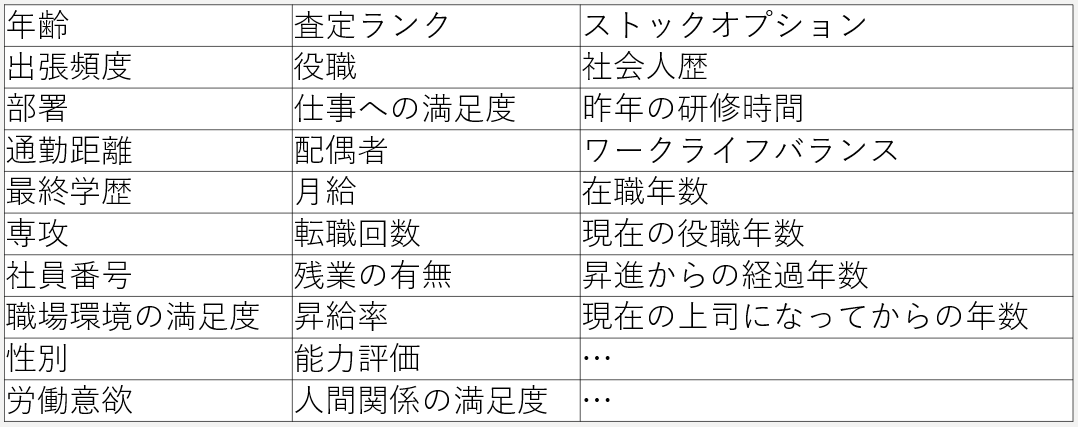

* **補足**：なお、このデータは本物ではなく、IBMのデータサイエンティストが、トレーニング用に作成してくれたものです（ありがたく使わせていただきましょう）
* **参照**：[IBM HR Analytics Employee Attrition & Performance | Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset)

### 0.1 日本語の文字化け（□□□）を訂正（おまじない）


In [ ]:
# 日本語フォントをダウンロードする。
! apt-get -y install fonts-ipafont-gothic

# キャッシュを削除する。
# 削除すべきキャッシュのファイル名は、Matplotlibがバージョンアップすると変わるため、
# 下記のrmでうまく行かない場合、! ls -ll /root/.cache/matplotlib/ でファイル名を確認
# 旧ファイル名：! rm /root/.cache/matplotlib/fontList.json
# 旧ファイル名：! rm /root/.cache/matplotlib/fontlist-v300.json

! rm /root/.cache/matplotlib/fontlist-v310.json   # 2019/10/31段階でのファイル名

### 0.2 ランタイムの再起動（おまじない）

日本語フォントを反映させるため、このタイミングでランタイムを再起動してから、  

→**再起動の方法：Colabメニュー → ランタイム → ランタイムを再起動**　　

再起動後に以降のセルを実行してください

In [ ]:
# 日本語フォントの設定
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

# memo
# plot時に↓のようにフォントを指定する方法もある
# jp_font = {'fontname':'IPAGothic'}
# plt.title('住宅価格のヒストグラム', **jp_font)

-------------

## 1 前処理（再実行）
* 解析に使用するライブラリをインポートします。
* 解析対象となる1470名分の社員データを入手します。
* データを、8対2の割合で、訓練用と検証用に分割します。
* 深さ=2の決定木で学習と予測を行います。
* 決定木を可視化します。
* 予測の正解率と再現率を確認します。

**注釈**：前回までの実習を1つのセルで行うため少々長文です↓（でも、今までやった内容を繋げただけなので、慌てなくても大丈夫）

In [ ]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt   # グラフ描画ライブラリ
import seaborn as sns             # 可視化ライブラリ
import cv2                        # 画像操作ライブラリ

# データを分割するライブラリを読み込む（おまじない）
from sklearn.model_selection import train_test_split

# マジックコマンド
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# sns.set(font="TakaoPGothic")

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')

# 画像サイズの設定
plt.rcParams['figure.figsize'] = (10, 6)

# wgetはウェブサーバからコンテンツを取得するダウンロードコマンドです
! wget https://nai-lab.com/practice/dataset/employee_x_jp.csv
! wget https://nai-lab.com/practice/dataset/employee_y_jp.csv

# 学習用データの読み込み
df_employee_x = pd.read_csv('/content/employee_x_jp.csv')
df_employee_y = pd.read_csv('/content/employee_y_jp.csv')

# train_test_split関数を利用してデータを分割する
train_x, valid_x, train_y, valid_y = train_test_split(df_employee_x, df_employee_y, train_size=0.8, random_state=0, stratify=df_employee_y)

train_y = train_y['退職'] # 型をSeriesに変換
valid_y = valid_y['退職'] # 型をSeriesに変換

## 2 決定木（再実行）

データの前処理まで行ったところで、まずは前回使用した「決定木（木の深さ=2）」で予測を行います。

### 2.1 木の深さ=2の場合

In [ ]:
# 決定木に必要なライブラリを読み込む（おまじない）
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

from sklearn.metrics import recall_score  # ライブラリのインポート（おまじない）
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')  # 再現率を測定する

from sklearn.metrics import accuracy_score  # ライブラリのインポート（おまじない）
print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！') # 正解率を測定する

**注釈**：正解率は84%なのに、再現率が8.5%と、さんざんな状況でしたね。

## 3 様々な評価指標


### 3.1 正解率/再現率

ここまでは「正解率」と「再現率」という2つの評価指標で精度を測定しました。そして、

* 「正解率だけを追い求めるのであれば、すべてNo（退職しない）と予測すれば良い（それはズルイ）」
* だから「本当に退職した人の中から、AIが退職すると予想できた人の割合=再現率」も合わせて評価する必要がある。

と前回の講義で学びました。しかし、よく考えてみましょう。今度は逆に「再現率を追い求めるのであれば、すべてYes（退職する）と予想すれば良い！」ということになるような気がしませんか？

「このひとは、退職しそうです」「あのひとも退職しそうです」と、甘々な予想で、どれもこれも「退職しそうな人」として分類してしまったら、たしかに再現率は100%（！？）になるのですが、それにどんな意味があるのでしょうか？（そしてまた、人事部の上司に怒られるのは目に見えています）

そこでもう一つの評価指標の「適合率」の出番です。

### 3.2 適合率

再現率と対をなす評価指標に「適合率」があります。混乱するので並べて紹介します。

* 適合率は「AIが退職すると予想した人の中で、実際に退職した人の割合」です。
* 再現率は「本当に退職した人の中から、AIが退職すると予想できた人の割合」でした。
* 正解率は「AIの予想（退職のYes/No）が、実際の結果（Yes/No）と同じだった割合」でした。

どうでしょうか？（少し混乱すると思うので、じっくり読んで考えてください）



In [ ]:
# ライブラリのインポート（おまじない）
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する

**注釈**：この段階でのAIモデルの適合率、再現率は上記の通りでした。

* 適合率が**57%**ということは、AIが退職する人を100名選んだとしたら、そのうちの57名が実際に退職したということです。

* 再現率が**8%**ということは、もし100名の退職する人がいたら、そのうちの8名をAIが見つけられたということです。


### 3.3 適合率と再現率の関係

木の深さを、5、10と変化させながら、適合率と再現率がどのように変化するのかを確認しましょう。


#### 木の深さ=5の場合

In [ ]:
# 決定木に必要なライブラリを読み込む（おまじない）
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

# ライブラリのインポート（おまじない）
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# ハイパーパラメータの設定（今回は木の深さを「5」に設定する）
dt = DecisionTreeClassifier(max_depth=5, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する

**注釈**：木の深さを5に増やしたところ、
* 適合率は 57%→**44%** に減少しました。
* 再現率は  8%→**23%** に増加しました。


#### 木の深さ=10の場合

In [ ]:
# 決定木に必要なライブラリを読み込む（おまじない）
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

# ライブラリのインポート（おまじない）
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# ハイパーパラメータの設定（今回は木の深さを「10」に設定する）
dt = DecisionTreeClassifier(max_depth=10, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する

**注釈**：木の深さを10に増やしたところ、
* 適合率は 57%→44%→**34%** に減少しました。
* 再現率は  8%→23%→**31%** に増加しました。


**補足**：この適合率と再現率の2つの評価指標は「片方を上げれば、片方が下がる」ようなペアの関係になっています。ですから、両方を同時に上げるような都合の良いことは出来ません。バランスを見ながら、適合率と再現率、そして正解率をどのアタリに着地させるかを、考えていきます。

### 3.4 目標の再設定

適合率、再現率、正解率という評価指標が出揃ったところで、今回の目標を改めて設定しましょう。

まず、適合率、再現率のどちらを優先するべきなのか？という点を考えます。

ここでは仮に退職者が10名いる部署で、**適合率**の高いAIモデルと、**再現率**の高いAIモデルの、それぞれを導入することを考えてみましょう。あなたはこの部署の責任者で、退職者を引き止める役目を持っています（責任重大ですね）


#### **適合率**を重視する場合


まず、**適合率**の高いAIの場合、例えば、AIが辞めると予測した人は5人だけだったとします。ただこの5人は、本当に辞める10人が高い確率で含まれています（適合率が高いAIモデルなので）。あなたは**この5人を引き留めることに集中できる**かもしれませんが、残りの5人を洗い出せなかったことに、やや不満を覚えるかもしれませんね。

#### **再現率**を重視する場合

次に、**再現率**の高いAIを導入した場合を考えます。AIが辞めると予想したのは20人でした（再現率の高いAIモデルなので…先程よりも4倍も多いですね）。この20名の中には、当然、本当に辞める10名以外の人も含まれています。先ほどのように、何も対策できずに退職されるケースは減る一方で、一度に20人の部下を気にかけるのは難しく、手間がかかります。20人のなかには本当は辞める気のない人も含んでいるので、そういう部下を必要以上に気にかけることになるのは、時間の無駄になる可能性もあります（まあ、部下とのコミュニケーションという意味では、気にかけることは無駄にはならないと思いますが）

#### 演習①：適合率と再現率

あなたがもし、退職予測AIを利用する立場（引き止める側）だとしたら、適合率の高いAI製品と、再現率が高いAI製品のどちらを採用しますか？

* **適合率**が高いAI製品：
  * メリット：確実に辞めるであろう人に絞ってピックアップしてくれるため、提示された少人数の対象者の引き止めに注力できる。
  * デメリット：退職する人を見逃してしまう恐れがある。

* **再現率**が高いAI製品：
  * メリット：辞めるかどうか、やや微妙な人もピックアップしてくれるため、退職する人を見逃す可能性が低くなる。
  * デメリット：少しでも退職の可能性があればピックアップしてしまうため、対象者の人数が増えてしまい、引き止め対策に掛かる時間が増えてしまう。

現実的には、適合率と再現率のバランスが大事であることは重々承知の上で、上の2つの製品のうち、どちらかを選ぶ必要があるとしたら、どちらを選びますか？

その「理由」や、導入後の「運営方法」（そのAIの予想をどう使っていくか）なども含めて、考察してまとめてください。



### 3.5 F1値

このように再現率と適合率は**トレードオフ**になっているのです。どちらにもそれぞれの良さがあり、どちらが優れたモデルか決めることはできません。そこで、両者のバランスをとった**F値**という指標があります。このF値が高ければ、バランスがよく性能が良いことを意味します。

* F1値 = (2×適合率×再現率) ÷ (適合率＋再現率）

In [ ]:
# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

In [ ]:
from sklearn.metrics import f1_score

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**補足**：市販されている「退職予測AI」には、的中率90%を謳っている製品も存在します。この90%というのは、正解率なのでしょうか？再現率なのでしょうか？それとも適合率なのでしょうか？ それをよく調べないで導入するとエライ目に合うかもしれないので注意が必要です。

**参考**：[的中率90％ってどういうこと？話題のHRテック「退職率予測」で理解しておきたいこと | AI専門ニュースメディア AINOW](https://ainow.ai/2018/02/06/132535/)

### 3.6 目標の再設定

これらを踏まえて、改めて今回の目標を再設定しましょう。まず、そもそものデータとしては、1470名の社員の中で、237名の退職者がいました。割合では、237/1470名=**約16%**の退職率でした。

すでに実用化している他社の退職予測AIの性能を確認すると、**「退職の予兆ありとAIが診断した人は、平均の倍以上退職していた」**という謳い文句がありました。

これは、適合率が平均の倍（今回のケースなら16%×2倍=32%）ということになります。

そこで、当面の目標としては「**適合率32%以上をキープしつつ、再現率ができるだけ高い（F1値ができるだけ高い）モデルを構築する**」ことを目指したいと思います。

## 4 説明変数の追加

それでは、ここからは精度（適合率と再現率）をバランス良く向上させるために、いろいろと試行錯誤を行いましょう。

まず、当初28項目あった説明変数ですが、前々回の演習で（分かりやすさを優先して）10項目まで絞っていました。もしかすると、ここで削除してしまった項目の中に、超大事な変数が隠れていて、精度に影響しているのかもしれません。

### 4.1 説明変数=28個の場合

そこで、今度は説明変数を一切、削らずに全28項目を使って、深さ2の決定木で学習と予測をさせてみます。

まずは、サーバから元データをダウンロードして、列名などを見やすく加工します。

In [ ]:
# wgetはウェブサーバからコンテンツを取得するダウンロードコマンドです
! wget https://nai-lab.com/practice/dataset/ibm_hr_dataset_jp.csv

# 学習用データの読み込み
df_employee = pd.read_csv('/content/ibm_hr_dataset_jp.csv')

# 目的変数の作成
df_employee_y = df_employee.loc[:,['退職']]

# 10項目を選択して新しいデータフレーム（df_x）を作成する
df_x = df_employee.loc[:,['年齢', '出張頻度', '部署', '通勤距離', '最終学歴', '専攻', '社員番号', '職場環境の満足度', '性別', '査定ランク', '労働意欲', '役職', '仕事への満足度', '配偶者','月給', '転職回数', '残業の有無', '昇給率', '能力評価', '人間関係の満足度', 'ストックオプション', '社会人歴', '昨年の研修時間', 'ワークライフバランス', '在職年数', '現在の役職年数', '昇進からの経過年数', '現在の上司になってからの年数']]
df_x.columns = ['年齢', '出張', '部署', '通勤', '学歴', '専攻', '社員番号', '職場満足度', '性別', '査定', '労働意欲', '役職', '仕事満足度', '配偶者','月給', '転職', '残業', '昇給率', '能力評価', '人間満足度', 'ストックオプション', '社会人歴', '研修時間', 'ワークライフバランス', '在職年数', '役職年数', '昇進年数', '上司年数']

# 冒頭の3件を表示
df_x.head(3)

そして、文字データ（性別、残業の他に、出張、部署、専攻、役職、配偶者）を、以前行ったOne-Hot表現で、0か1かに変換します（文字データのままではAIに学習させられないのでしたね）


In [ ]:
# One-Hot表現に変換する(多重共線性を回避)
df_x = pd.get_dummies(df_x, columns=['性別'], drop_first=True)
df_x = pd.get_dummies(df_x, columns=['残業'], drop_first=True)

# One-Hot表現に変換する(多重共線性を無視)
df_x = pd.get_dummies(df_x, columns=['出張'], drop_first=True)
df_x = pd.get_dummies(df_x, columns=['部署'], drop_first=True)
df_x = pd.get_dummies(df_x, columns=['専攻'], drop_first=True)
df_x = pd.get_dummies(df_x, columns=['役職'], drop_first=True)
df_x = pd.get_dummies(df_x, columns=['配偶者'], drop_first=True)

df_employee_x = df_x
df_employee_x

One-Hot表現の項目が多いので、列の後半はだいぶ見づらい感じですが、とにかくこれで準備OKです。では、いよいよ全28項目を決定木（深さ=2）に入れて学習＆予測させてみましょう。

In [ ]:
# train_test_split関数を利用してデータを分割する
train_x, valid_x, train_y, valid_y = train_test_split(df_employee_x, df_employee_y, train_size=0.8, random_state=0, stratify=df_employee_y)

train_y = train_y['退職'] # 型をSeriesに変換
valid_y = valid_y['退職'] # 型をSeriesに変換

# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**注釈**：説明変数を10個から28個にボリュームアップした結果…
* 適合率は 57%→**57%** で変化ありませんでした。
* 再現率は  8%→**8%** で変化ありませんでした。
* Ｆ１値は0.14→**0.14** で変化ありませんでした。

なんと、まったく変化がありませんでした（涙）

可視化された決定木を見ると、以前は「上司年数」だったところが「社会人歴」になっていて、少し違いはあるのですが、どうやら大きな影響はないようです…

## 5 訓練と検証のバランス

これで諦めてはデータサイエンスはやってられません。次なる手を考えます。

### 5.1 訓練データが少ない？

次に考えられるのは「訓練用のデータが少なすぎるのではないか？」という仮説です。今回は、訓練と検証のデータを、8対2で分割しています。これを、9対1にして、訓練データを増やせば、もっと賢いAIが作れるかもしれません。

仮説を思いついたら、とにかく手を動かして実験してみましょう。

と、その前に、説明変数を28個から、10個に戻しておきましょう（以下のセルを実行してください）

In [ ]:
# wgetはウェブサーバからコンテンツを取得するダウンロードコマンドです
! wget https://nai-lab.com/practice/dataset/employee_x_jp.csv
! wget https://nai-lab.com/practice/dataset/employee_y_jp.csv

# 学習用データの読み込み
df_employee_x = pd.read_csv('/content/employee_x_jp.csv')
df_employee_y = pd.read_csv('/content/employee_y_jp.csv')

**補足**：なぜ、せっかく用意した28個の説明変数を、またわざわざ10個に戻すのでしょうか？　実は「説明変数は多すぎても、あまり良くない」というのが理由です。具体的には「過学習」とか「汎化性能」というものと関係があるのですが、それについてはまた別な機会の講義にて。

#### 演習②：訓練データの増量

以下のプログラムの空欄を埋めて、訓練データと検証データの割合を9対1にしましょう（訓練データが90%で、検証データが10%の割合ですよ）

In [ ]:
# train_test_split関数を利用してデータを分割する
train_x, valid_x, train_y, valid_y = train_test_split(df_employee_x, df_employee_y, train_size=■空欄■, random_state=0, stratify=df_employee_y)

train_y = train_y['退職'] # 型をSeriesに変換
valid_y = valid_y['退職'] # 型をSeriesに変換

print(
    '訓練データ:',
    train_x.shape,
    train_y.shape,

    '検証データ:',
    valid_x.shape,
    valid_y.shape
)

**補足**：演習②の成功例は以下の通りです。このようになれば成功です。

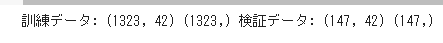

では、あらためて、訓練データを増量した状態で、決定木（深さ=2）に、学習＆予測をさせてみましょう。

In [ ]:
# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**注釈**：訓練データの割合をボリュームアップした結果…
* 適合率は 57%→**66%** で上昇しました！
* 再現率は  8%→**8%** で変化ありませんでした。
* Ｆ１値は0.14→**0.14** で変化ありませんでした。

適合率が増えたのは良かったです！　しかし再現率には変化がありませんでした。再現率が8%というのは、いくらなんでも少なすぎるので、もう少し、再現率を改善したいです。


### 5.2 検証データが少ない？

次に思いついたのは、「検証データが少なすぎるのではないか？」という仮説です。

これは現実世界の試験勉強に例えるならば、実力を測定するために模擬試験を実施したものの、模擬試験の問題数が少なすぎて、さらに「たまたま、解けないような問題ばかりが集まっていた」という嫌な状況です。

ですので、訓練と検証のデータを、思い切って、5対5などで分割して、検証用のデータをボリュームアップして検証したいと思います（その分、訓練用のデータが少なくなるのはリスキーに感じますが、まずは試してみましょう）

#### 演習③：検証データの増量

以下のプログラムの空欄を埋めて、訓練データと検証データの割合を5対5にしましょう。

In [ ]:
# train_test_split関数を利用してデータを分割する
train_x, valid_x, train_y, valid_y = train_test_split(df_employee_x, df_employee_y, train_size=■空欄■, random_state=0, stratify=df_employee_y)

train_y = train_y['退職'] # 型をSeriesに変換
valid_y = valid_y['退職'] # 型をSeriesに変換

print(
    '訓練データ:',
    train_x.shape,
    train_y.shape,

    '検証データ:',
    valid_x.shape,
    valid_y.shape
)

**補足**：演習③の成功例は以下の通りです。このようになれば成功です。

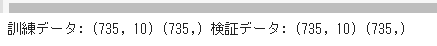

では、あらためて、検証データを増量した状態で、決定木（深さ=2）に、学習＆予測をさせてみましょう。

In [ ]:
# ハイパーパラメータの設定（今回は木の深さを「2」に設定する）
dt = DecisionTreeClassifier(max_depth=2, random_state=0)

# 学習
dt.fit(train_x, train_y)

# 決定木の可視化
dot_data = export_graphviz(dt, filled=True, rounded=True ,feature_names=train_x.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_employee.png')

### 描画サイズ設定 ###
plt.figure(figsize=(20,20))
plt.grid(b=False)

# 画像の読み込み
img_target = cv2.imread('tree_employee.png',  flags=cv2.IMREAD_COLOR)  # 図面（target）

#画像の確認(opencvとmatplotでRGBの順序が違うため変換し表示)
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))

# 予測
dt_pred = dt.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(dt_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**注釈**：検証データの割合をボリュームアップした結果…
* 適合率は 57%→**63%** と上昇しました！
* 再現率は  8%→**17%** と上昇しました！
* Ｆ１値は0.14→**0.27** と上昇しました！

適合率、再現率ともに上昇しました！　この仮説はそれほど筋が悪くないのではないか？と思います。なお、可視化された決定木を見ると、第一の要因が「月給」で、第二の要因が「残業」に変化しているのも、なかなか興味深いです（やっぱり…という感じですが）


**補足**：なお、本来であれば、訓練用にせよ検証用にせよ、データを増やしたいのなら、今回のように割合を変えるのではなく、そもそも「もっとたくさんのデータを集めるべし」というのが普通です。ですが、どうしても手元にあるデータだけで何とかしなければいけないケースもありますので、今回も、このように割合を変えて逃げました（繰り返しますが、本来だったら、データを追加で収集する工夫を考えてくださいね）

## 6 様々な機械学習の手法

決定木の精度を上回る精度を出すために、ここからは機械学習による分類問題でよく使われるメジャーな手法を2つ試してみます。今回は手法を変えることでどの程度、精度が向上（または低下）するのかを体験するのが趣旨です。そのため各手法の詳細なロジックについては省略しますが、手法の名称くらいは覚えておくと、役に立つと思います（ロジックの詳細はまた別の講義にて）

1. **決定木** ← ここまでに試した
2. **ランダムフォレスト** ← これから試そう
3. **LightGBM** ← これから試そう

なお、主要な機械学習手法の特徴を以下にまとめました、参考にしてください。

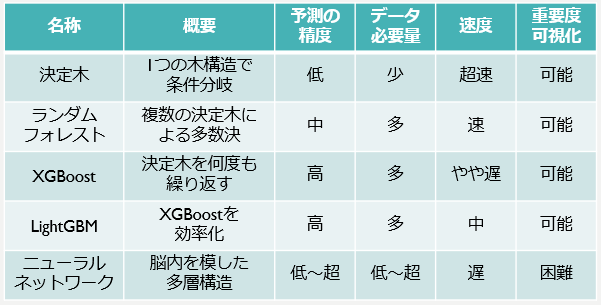

### 6.1 ランダムフォレスト

ランダムフォレストは、いままで使ってきた決定木を、複数個作って、それらで多数決を取って、最終的な予測判断をする手法です。

ランダムフォレストのフォレストとは「森」や「林」のことです。決定木が「木」でしたので、このランダムフォレストは、木が複数集まって「森」というわけですね（洒落たネーミングです）　さて、「木」と「森」とでは、どちらの精度が上になるでしょうか？　さっそく試してみましょう。



In [ ]:
# ランダムフォレストに必要なライブラリを読み込む
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)

# 学習
rf.fit(train_x, train_y)

# 予測
rf_pred = rf.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(rf_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**注釈**：ランダムフォレストで学習＆予測した結果…
* 適合率は決定木の 63% から **71%** に上昇しました！
* 再現率は決定木の 17% から **21%** に上昇しました！
* Ｆ１値は決定木の0.27 から **0.32** と上昇しました！

これは「森」の効果はテキメンです。「木」よりも「森」、強し！

ランダムフォレストは、決定木のような判断分岐の可視化は行なえませんが、その代わりに、予測の判断として何を重要視したのかを、グラフで可視化できます。さっそく確認してみましょう。

In [ ]:
# 重要度の抽出
feature_importances = pd.Series(rf.feature_importances_, index=train_x.columns).sort_values(ascending=True)
feature_importances = feature_importances.to_frame(name='重要度').sort_values(by='重要度', ascending=False)

# TOP20可視化
feature_importances[0:20].sort_values(by='重要度').plot.barh()
plt.legend(loc='lower right')
plt.show()

**注釈**：ランダムフォレストは「月給」「年齢」「上司年数」などを重要な指標として挙げました。決定木のときよりも「年齢」の優先順位が高くなっていますね。

なお、ランダムフォレストは複数の決定木で多数決を取りましたが、このように複数のモデル（学習器）を融合させて1つの学習モデルを生成する手法を**アンサンブル学習**と呼びます。精度向上を目指す際に欠かせないテクニックになります。

### 6.2 LightGBM

LightGBMも決定木を組み合わせた手法です。データ分析競技の上位ランカーたちも好んで使用する人気の手法です。

仕組みは、ランダムフォレストと少し違っていて、決定木を何度も何度も繰り返すことで、精度を上げていきます。このとき、ただ単に繰り返すだけでなく、その直前の決定木が間違えたところを中心に学習させる「ブースティング」と呼ばれるテクニックを用いているのが特徴です。現実世界で言えば、試験の問題集を何周も解くときに、2回目は1回目で間違えた問題を、3回目は2回目で間違えた問題を中心に学習することで、徐々に弱点を減らしていこう…という学習方法に近いでしょうか。

このLightGBMもプログラム自体は（使うだけれあれば）それほど難しいことはなく、ここまでの決定木やランダムフォレストと同じ要領で使用することができます。さっそく試してみましょう。

In [ ]:
# LightGBMに必要なライブラリを読み込む
import lightgbm as lgb
gbm = lgb.LGBMClassifier(random_state=0)

# 学習
gbm.fit(train_x, train_y)

# 予測
gbm_pred = gbm.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(gbm_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する

**注釈**：LightGBMで学習＆予測した結果…
* 適合率は決定木の 63%、ランダムフォレストの 71% から、**62%**に減少しました。
* 再現率は決定木の 17%、ランダムフォレストの 21% から、**30%**に上昇しました！
* Ｆ１値は決定木の0.27、ランダムフォレストの 0.32から、**0.40**に上昇しました！

LightGBMによって、適合率はやや減少しましたが、再現率が30%まで上昇しました。また両者のバランスを測るF1値が0.40に上昇しましたので、これは良い方向に向かっていると考えて良いでしょう。

LightGBMでも重要視した説明変数を可視化することができますので、確認してみましょう。

In [ ]:
# 重要度の抽出
feature_importances = pd.Series(gbm.feature_importances_, index=train_x.columns).sort_values(ascending=True)
feature_importances = feature_importances.to_frame(name='重要度').sort_values(by='重要度', ascending=False)

# TOP20可視化
feature_importances[0:20].sort_values(by='重要度').plot.barh()
plt.legend(loc='lower right')
plt.show()

**注釈**：いかがでしょうか、決定木やランダムフォレストと、似ている部分もあれば、違う部分もありますね。

「決定木」「ランダムフォレスト」「LightGBM」は、どれも同じ「木」という構造を使って予測をするモデルですが、いかがでしたでしょうか。


## 7 不均衡データの扱い

さて、ここからは更に精度向上を目指して、考えられる限りの工夫を盛り込んでいきます。ここであらためて、その訓練用データ735件のうち、雇用中と退職者の人数を確認します。



In [ ]:
# 訓練用データ（目的変数）の偏りを確認する
np.unique(train_y, return_counts=True)

In [ ]:
# 検証用データ（目的変数）の偏りを確認する
np.unique(valid_y, return_counts=True)

訓練用と検証用で1件の違いはありましたが、ほぼ同じ割合で分割できています。

このとき（当たり前なのですが）雇用中の人数に比べて、退職者の人数が圧倒的に少ないことが、気になります。

このようなバランスの悪いデータを「不均衡データ」と呼ぶのですが、このような不均衡データを使って、何らかのAIモデル（今回は決定木）を学習させる場合は、

* 多数派のデータを、少数派のデータに合わせるアンダーサンプリング
* 少数派のデータを、多数派のデータに合わせるオーバーサンプリング

というテクニックが用いられることがあります。





### 7.1 オーバーサンプリング

ここでは、オーバーサンプリングをして、少数派（退職者）のデータを水増しすることで、訓練用データのバランスを調整してみましょう。

少数派のクラス（今回なら退職がYesの人たち）を、多数派のクラス（退職がNo）の件数の50%になるように、オーバーサンプリングで水増しを行います。

In [ ]:
# # train_test_split関数を利用してデータを分割する
# train_x, valid_x, train_y, valid_y = train_test_split(df_employee_x, df_employee_y, train_size=0.5, random_state=0, stratify=df_employee_y)

# train_y = train_y['退職'] # 型をSeriesに変換
# valid_y = valid_y['退職'] # 型をSeriesに変換

# print(
#     '訓練データ:',
#     train_x.shape,
#     train_y.shape,

#     '検証データ:',
#     valid_x.shape,
#     valid_y.shape
# )

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.5, random_state=10)
train_x_over, train_y_over = oversample.fit_resample(train_x, train_y)

In [ ]:
# 訓練用データ（目的変数）の偏りを確認する
np.unique(train_y_over, return_counts=True)

**注釈**：少数派（退職=Yes）のデータが、118件→308件に増えました。


### 7.2 LightGBM(再)

オーバーサンプリングで水増ししたデータをもとに、先程一番、F1値が高かったLightGBMで学習＆予測をさせてみましょう。

In [ ]:
# LightGBMに必要なライブラリを読み込む
import lightgbm as lgb
gbm = lgb.LGBMClassifier(random_state=0)

# 学習
gbm.fit(train_x_over, train_y_over)

# 予測
gbm_pred = gbm.predict(valid_x)

y_true = pd.get_dummies(valid_y, drop_first=True)
y_true = y_true['Yes'] # 型をSeriesに変換
y_pred = pd.get_dummies(gbm_pred, drop_first=True)
y_pred = y_pred['Yes'] # 型をSeriesに変換

print(f'適合率は…{precision_score(y_true, y_pred)}でした！')  # 適合率を測定する
print(f'再現率は…{recall_score(y_true, y_pred)}でした！')     # 再現率を測定する
print(f'Ｆ１値は…{f1_score(y_true, y_pred)}でした！')         # Ｆ１値を測定する
print(f'正解率は…{accuracy_score(y_true, y_pred)}でした！')   # 正解率を測定する

**注釈**：オーバーサンプリングで水増しした結果…
* 適合率は水増し前の 62% から、**48%**に減少しました。
* 再現率は水増し前の 30% から、**40%**に上昇しました！
* Ｆ１値は水増し前の0.40から、**0.43**に上昇しました！

水増しをすることで、適合率は下がりましたが、再現率が大幅に上昇しました。その結果、F1値も上昇しましたので、オーバーサンプリングは「効果あり」と判断できます。

## 8 まとめ

長かった演習もここで一区切りとなります。いかがだったでしょうか？　ここで最後の最後に、まとめの演習を2つ用意しました。


### 演習④：アピール文の考察

最終的に完成したモデルは、退職者の割合が**16%**の企業で実験したところ…

* 適合率：**48%**（AIがピックアップした100名の中で、本当に辞める人が48名だ）
* 再現率：**40%**（100名の退職者のうち、40名を事前にAIがピックアップできる）
* 正解率：**83%**

というものが出来上がりました。さてあなたは、上司からこのAIを、社外に向けて一般販売することを検討するように指示されました。

そのとき、あなたであれば、このAIの宣伝に用いる「売り文句（アピール文）」をどのようにしますか？

「100発100中！退職者予測はAIにおまかせ！」みたいな、明らかに怪しげなアピール文はちょっとアレですが、それでも「嘘のない程度に、そしてお客さんも興味を持ってくれそうな」アピール文を、自由に考えてみてください。



### 演習⑤：演習を終えて

ここまで長きに渡る演習、お疲れ様でした。思ったよりも大変なところもあったのでしょうか？　そして想像していた以上にコツコツと地味な作業の連続だったり、思ったよりも精度が上がらなかったり、数学的な要素が絡んでくる部分も多かったりと、イメージしていたAIの仕事と違う部分も多々あったのではないでしょうか？

データの入手→前処理→モデルの作成（決定木）→チューニング（木の深さ・説明変数の増加・検証データの増量）→機械学習手法の変更（ランダムフォレスト・LightGBM）→データのオーバーサンプリング（水増し）→宣伝文句（アピール文）の検討…などなど。

この「退職予測AI」にチャレンジした内容を振り返りながら、最後にあなたの感想を記入してください。思ったことをなんでも結構です。よろしくお願いします！


---